# DESAFÍO N° 2 - MODELADO

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor.alphas import manual_alphas

In [100]:
data = pd.read_csv("salida_desafio_1.csv")
data.sample(5)

,Unnamed: 0,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,properati_url,ambientes,...,villa_crespo,hidromasaje,san_telmo,vista,sauna,losa_radiante,capital_federal,impecable,interwin,doble_circulacion
16,16,apartment,Caballito,Argentina,-34.622211,-58.439128,110000.0,2.0,http://www.properati.com.ar/15buk_venta_depart...,3.0,...,0,0,0,0,0,0,0,0,0,0
10965,10965,house,Floresta,Argentina,-34.640393,-58.488942,170000.0,3.0,http://www.properati.com.ar/18w8r_venta_casa_f...,NaN,...,0,0,0,0,0,0,0,0,0,0
17586,17586,apartment,Belgrano,Argentina,-34.562700,-58.458290,160000.0,3.0,http://www.properati.com.ar/1ada4_venta_depart...,4.0,...,0,0,0,0,0,0,0,0,0,0
12612,12612,apartment,Caballito,Argentina,-34.621668,-58.439445,68000.0,2.0,http://www.properati.com.ar/19a49_venta_depart...,2.0,...,0,0,0,0,0,0,0,0,0,0
10050,10050,store,Barrio Norte,Argentina,-34.596326,-58.409886,128000.0,93.0,http://www.properati.com.ar/18m7s_venta_local_...,NaN,...,0,0,0,0,0,0,0,0,0,0


## Reducción de volumen de datos

Decidimos elegir como dataset de trabajo los barrios dentro de la Comuna 13: Belgrano, Nuñez y Colegiales

Esta decisión la tomamos ya que es una de las comunas con mayor desarrollo inmobiliario en la CABA. Vamos a trabajar con 4122 datos de tres barrios porteños.

In [101]:
data2 = data[(data.barrio == "Palermo") | (data.barrio == "Palermo Hollywood") | (data.barrio == "Palermo Soho") | (data.barrio == "Palermo Chico") | (data.barrio == "Palermo Viejo")]
data2.shape

(4083, 57)

## Preparación del DATASET

In [102]:
data2.sample(10)
data2.columns

data2.drop(['Unnamed: 0', 'pais', 'precio_usd', 'villa_urquiza', 'barrio_norte', 'villa_crespo', 'lujoso', 'san_telmo',
          'capital_federal', 'impecable', 'interwin', 'properati_url', 'properati_url_clean'], axis = 1, inplace = True)

In [103]:
data2['piso'] = data2.piso.apply(lambda x: np.NaN if x > 30 else x)
data2['ambientes'] = data2.ambientes.apply(lambda x: np.NaN if x > 8 else x)
data2['sup_total'] = data2.sup_total.apply(lambda x: np.NaN if x == 0 else x)

In [104]:
a = data2[data2.tipo_prop == "apartment"].piso.fillna(int(data2.piso.mode()))
b = data2[data2.tipo_prop != "apartment"].piso.fillna(0)

piso = a.append(b)

data2['piso'] = data2.piso.fillna(piso)

data2.ambientes.fillna(int(data2.ambientes.mode()), inplace = True)

data2.isnull().sum()

data2 = data2[data2.sup_total.notnull()]

data = data2[data2.precio_x_m2_usd.notnull()]

## Modelado

#### Preparación de dummies y categoricas

In [105]:
a = pd.get_dummies(data[['tipo_prop']])
a.drop(['tipo_prop_apartment'], inplace= True, axis = 1)

data = pd.merge(data, a, left_index= True, right_index= True)

In [106]:
a = pd.get_dummies(data[['barrio']])
a.drop(['barrio_Palermo'], inplace= True, axis = 1)

data = pd.merge(data, a, left_index= True, right_index= True)

In [107]:
data = data[data.precio_x_m2_usd < 12000]

## Feature Engineering

In [108]:
a = data.sup_total - data.sup_cubierta
data['sup_libre'] = a.apply(lambda x: 0 if x <= 0 else x)
data['por_sup_libre'] = data.sup_libre / data.sup_total
data['por_sup_cubierta'] = data.sup_cubierta/data.sup_total

data['ambientes'] = data.ambientes.apply(lambda x: 1 if x == 0 else x)
data['tamaño_ambiente'] = data['sup_cubierta'] / data['ambientes']


data['sup_cubierta_2'] = np.square(data.sup_cubierta)
data['sup_total_2'] = np.square(data.sup_total)
data['sup_libre_2'] = np.square(data.sup_libre)


data['comisarias_2'] = np.square(data.comisarias)


a = data.parrilla + data.piscina + data['sum'] + data.gimnasio + data.sauna
data['amenity'] = a.apply(lambda x: 1 if x > 0 else 0)


data['patio_parrilla'] = data.parrilla * (data.patio + data.jardin)
data['patio_parrilla'] = data.patio_parrilla.apply(lambda x: 1 if x >= 1 else x)
data['patio_parrilla_piscina'] = data.parrilla * data.piscina * (data.patio + data.jardin)
data['patio_parrilla_piscina'] = data.patio_parrilla_piscina.apply(lambda x: 1 if x >= 1 else x)


a = data.jardin + data.patio
data['patios'] = a.apply(lambda x: 1 if x > 0 else 0)
data['libre_abierto'] = data.sup_libre * data.patios


a = data.jardin + data.patio + data.terraza + data.balcon
data['espacio_abierto'] = a.apply(lambda x: 1 if x > 0 else 0)


data['piso_luminoso'] = data.piso.apply(lambda x: 1 if x > 5 else 0)


data['subtes_cat'] = data.subtes.apply(lambda x: 'ninguno' if x == 0 else ('uno' if x == 1 else 'dos_o_mas'))
data['bicis_cat'] = data.bicis.apply(lambda x: 'ninguna' if x == 0 else 'alguna')


a = pd.get_dummies(data[['subtes_cat', 'bicis_cat']])
a.drop(['subtes_cat_ninguno', 'bicis_cat_ninguna'], inplace= True, axis = 1)
data = pd.merge(data, a, left_index= True, right_index= True)
data.drop(['subtes_cat', 'bicis_cat'], axis = 1, inplace= True)

In [109]:
data.drop(['subte_linea_a', 'subte_linea_c', 'subte_linea_e'], axis = 1, inplace=True)

<AxesSubplot:xlabel='precio_x_m2_usd'>

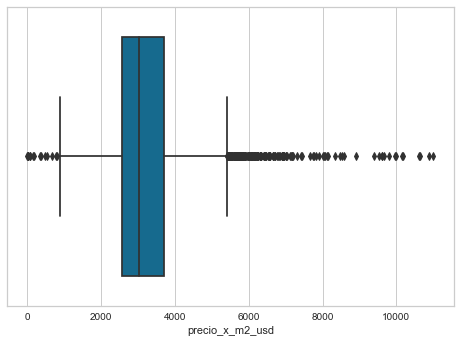

In [110]:
sns.boxplot(data.precio_x_m2_usd)

## CLUSTERING

Una posibilidad que podría mejorar el rendimiento del algoritmo es generar clusters dentro del barrio elegido según el tipo de propiedad y usando como variables el rpecio_x_m2 y la localización geográfia (lat/lon). Eso podría ayudarnos a ubicar patrones geográficos en los precios

In [111]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### Apartments

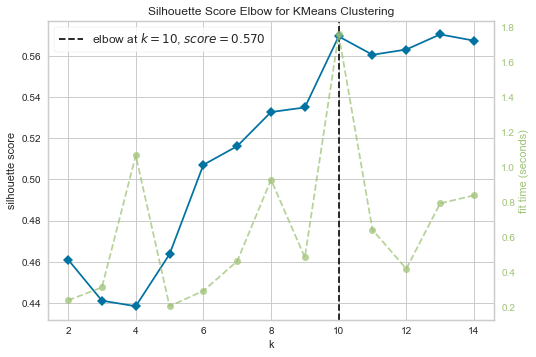

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [112]:
data_clus = data

data_clus = data_clus[(data_clus.tipo_prop == "apartment")]
data_clus = data_clus[['lat', 'lon','tipo_prop']]

# data_clus = data_clus[data_clus.precio_x_m2_usd.notnull()]

# escalador = StandardScaler()
# X = escalador.fit_transform(data_clus.drop('tipo_prop', axis = 1))

X = data_clus.drop('tipo_prop', axis = 1)

km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k = (2,15), metric = 'silhouette')

visualizer.fit(X)
visualizer.show()

In [113]:
km_model = KMeans(n_clusters=4)

km_model.fit(X)

clusters = pd.Series(km_model.predict(X), index = data_clus.index, name = 'clusters_apartment')
data_clus_apartment = data_clus.join(clusters)

### Houses

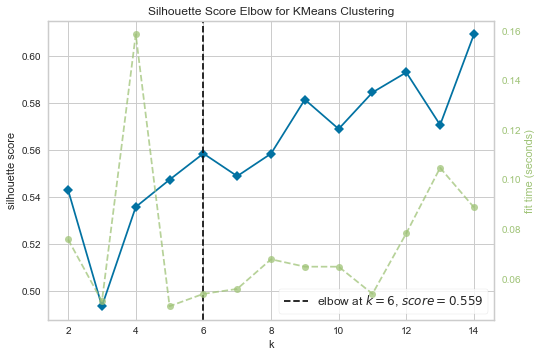

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [114]:
data_clus = data

data_clus = data_clus[(data_clus.tipo_prop == "house")]
data_clus = data_clus[['lat', 'lon','tipo_prop']]

# data_clus = data_clus[data_clus.precio_x_m2_usd.notnull()]

# escalador = StandardScaler()
# X = escalador.fit_transform(data_clus.drop('tipo_prop', axis = 1))

X = data_clus.drop('tipo_prop', axis = 1)

km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k = (2,15), metric = 'silhouette')

visualizer.fit(X)
visualizer.show()

In [115]:
km_model = KMeans(n_clusters=3)

km_model.fit(X)

clusters = pd.Series(km_model.predict(X), index = data_clus.index, name = 'clusters_house')
data_clus_house = data_clus.join(clusters)

In [116]:
data = data.join(data_clus_apartment.clusters_apartment)
data = data.join(data_clus_house.clusters_house)

In [117]:
dummy_apartment = pd.get_dummies(data.clusters_apartment, dummy_na=True)
dummy_apartment.columns = ['ap_0','ap_1', 'ap_2', 'ap_3', 'Vacio']
dummy_apartment.drop(['Vacio'], inplace=True, axis = 1)

dummy_house = pd.get_dummies(data.clusters_house, dummy_na=True)
dummy_house.columns = ['h_0', 'h_1', 'h_2', 'Vacio']
dummy_house.drop(['Vacio'], inplace=True, axis = 1)

data = data.join(dummy_apartment)
data = data.join(dummy_house)

In [118]:
data.drop(['barrio', 'tipo_prop', 'lat', 'lon', 'clusters_house', 'clusters_apartment'], axis = 1, inplace= True)

### Train_test_split
Separamos el dataset en un segmento de entrenameinto y otro de testeo

In [119]:
X = data.drop('precio_x_m2_usd', axis = 1)
y = data.precio_x_m2_usd

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 555)


Xs = data.drop('precio_x_m2_usd', axis = 1)
ys = data.precio_x_m2_usd

std = StandardScaler()

X_std = Xs[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 
           'comisarias', 'sup_libre', 'por_sup_libre', 'por_sup_cubierta',
       'tamaño_ambiente', 'sup_cubierta_2', 'sup_total_2', 'sup_libre_2',
       'comisarias_2', 'libre_abierto']]

X_std = std.fit_transform(X_std)

Xs[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 'comisarias', 'sup_libre', 'por_sup_libre', 'por_sup_cubierta','tamaño_ambiente', 'sup_cubierta_2', 'sup_total_2', 'sup_libre_2','comisarias_2', 'libre_abierto']] = X_std

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, shuffle = True)

In [120]:
print(X_train.shape)
print(X_test.shape)

(2618, 68)
(873, 68)


### Regresión Lineal Multiple

In [121]:
model_lrm = LinearRegression()

model_lrm.fit(X_train, y_train)
print(model_lrm.score)

y_predict = model_lrm.predict(X_test)

print("El score obtenido en el dataset de training fue de:", r2_score(y_train, model_lrm.predict(X_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(y_test, y_predict))

<bound method RegressorMixin.score of LinearRegression()>
El score obtenido en el dataset de training fue de: 0.26204336633480274
El score obtenido en el dataset de testing fue de: 0.27077799369218325


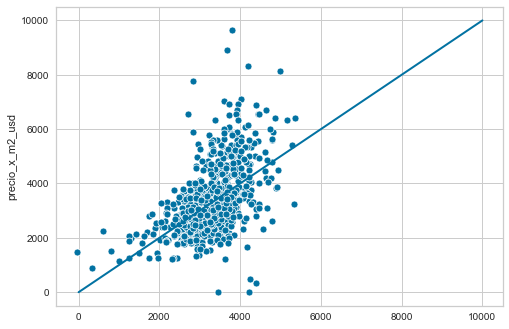

In [122]:
sns.scatterplot(y = y_test, x = y_predict)
plt.plot([0, 10000], [0, 10000], linewidth=2)
plt.show()

## WARNINGS

Importamos un metodo para evitar los print de warnings en casos donde la solución no converge

In [123]:
import warnings
warnings.filterwarnings('ignore')

## LASSO

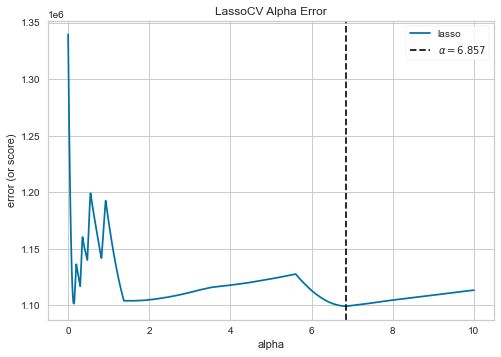

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [127]:
model_lasso = LassoCV(cv = 3, alphas = np.linspace(0,10,5000))
visualizer = AlphaSelection(model_lasso)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

In [132]:
model_lasso = LassoCV(cv = 3, alphas = np.linspace(0,10,5000))

model_lasso.fit(Xs_train, ys_train)
y_predict = model_lasso.predict(Xs_test)

print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_lasso.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))
print()
coeficientes = list(model_lasso.coef_)
nombre = list(Xs.columns)

coef = pd.DataFrame(coeficientes, index = nombre)
coef

El score obtenido en el dataset de training fue de: 0.23583061310349573
El score obtenido en el dataset de testing fue de: 0.2218367719509684



,0
piso,-0.000000
ambientes,-5.174690
sup_total,0.000000
sup_cubierta,260.716251
subtes,-38.850669
...,...
ap_2,259.196704
ap_3,286.068097
h_0,-0.000000
h_1,0.000000


In [134]:
coef.columns = ['a']
np.abs(coef).sort_values(ascending = False, by = 'a')[:40]

,a
tipo_prop_store,555.002074
gimnasio,453.664449
barrio_Palermo Chico,352.609261
suite,314.858903
ap_3,286.068097
sup_cubierta,260.716251
ap_2,259.196704
sup_libre,247.134804
subte_linea_b,245.609398
vestidor,223.556145


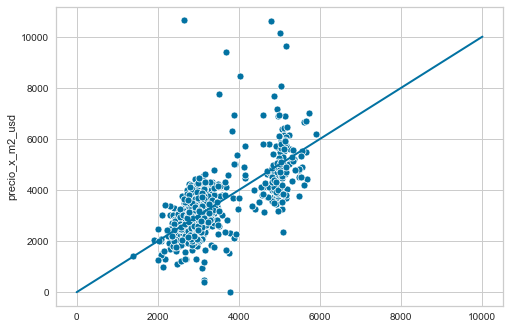

In [247]:
sns.scatterplot(y = ys_test, x = y_predict)
plt.plot([0, 10000], [0, 10000], linewidth=2)
plt.show()

## RIDGE

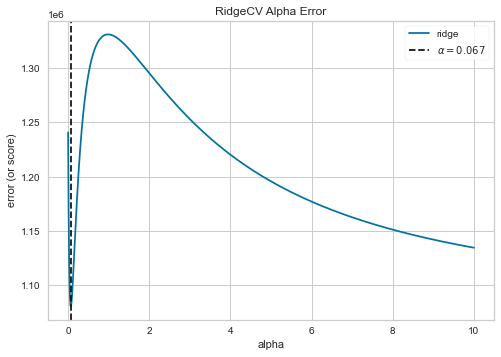

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [131]:
model_ridge = RidgeCV(alphas = np.linspace(0.001,2,5000))
visualizer = AlphaSelection(model_ridge)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

In [130]:
model_ridge = RidgeCV(cv = 3, alphas = np.linspace(0.01,2,500))


model_ridge.fit(Xs_train, ys_train)
y_predict = model_ridge.predict(Xs_test)

print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_ridge.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))
print()
coeficientes = list(model_ridge.coef_)
nombre = list(Xs.columns)

coef = pd.DataFrame(coeficientes, index = nombre)
coef

El score obtenido en el dataset de training fue de: 0.26998126448162196
El score obtenido en el dataset de testing fue de: 0.23771354724467153



,0
piso,38.975011
ambientes,-137.668678
sup_total,-4670.954765
sup_cubierta,4639.765543
subtes,38.490777
...,...
ap_2,114.087840
ap_3,203.473347
h_0,-633.047378
h_1,1223.440195


## ELASTICNET

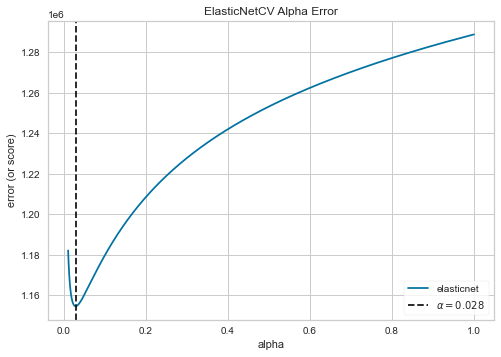

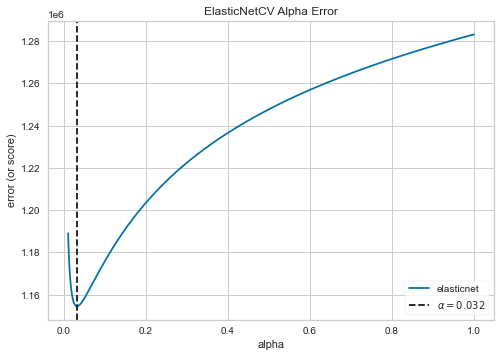

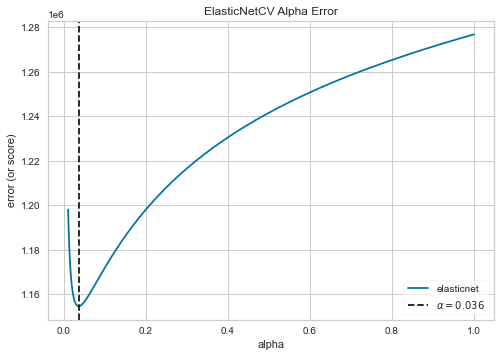

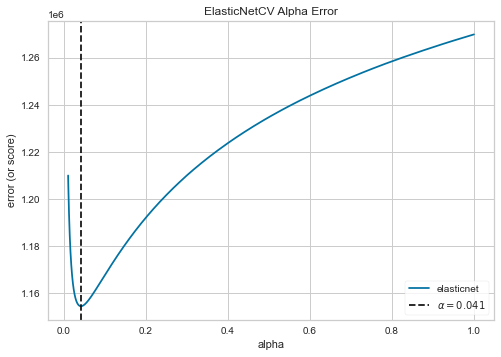

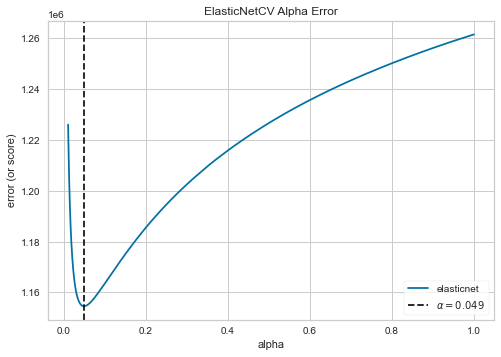

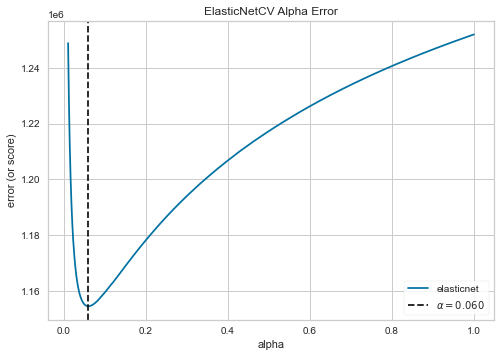

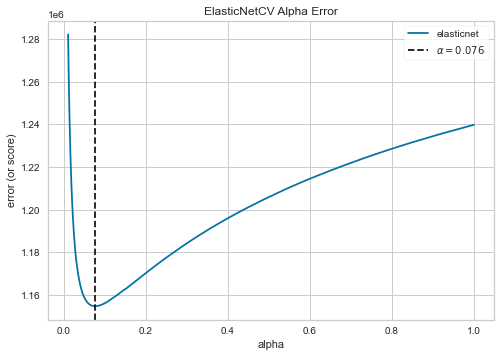

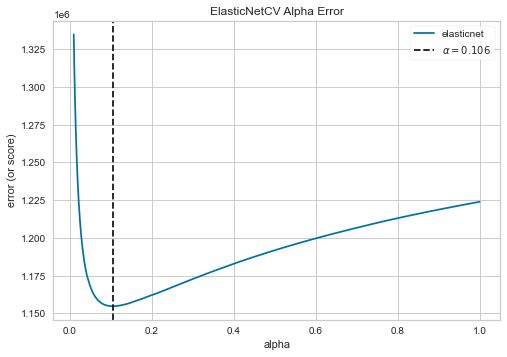

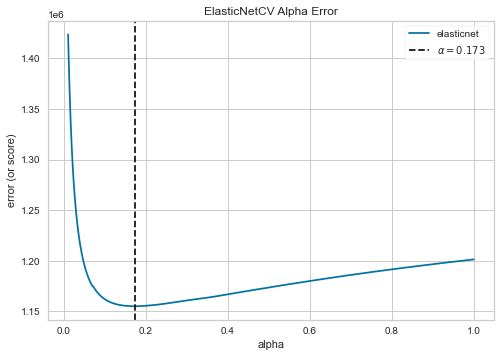

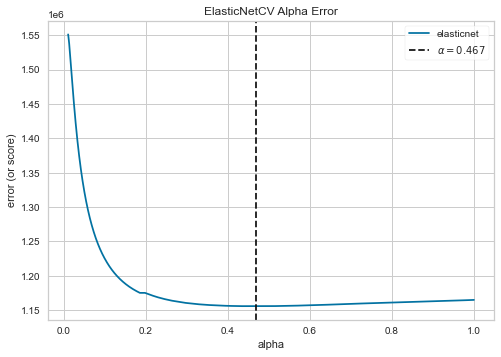

[0.23349883027113993,
 0.23349158711396834,
 0.23349472320429843,
 0.23348603606296559,
 0.23349361013268877,
 0.23348960360412763,
 0.23347596896910427,
 0.23346725622001863,
 0.2334655337311896,
 0.23345488097378897]

In [97]:
metrica_r2 = []
for x in np.linspace(0.1,0.95,10):
    model_eln = ElasticNetCV(cv = 3, l1_ratio=x, alphas = np.linspace(0.01,1,5000))
    visualizer = AlphaSelection(model_eln)
    visualizer.fit(Xs_train, ys_train)
    visualizer.show()

    
    model_eln = ElasticNetCV(cv = 3, l1_ratio= visualizer.l1_ratio_, alphas = visualizer.alphas)

    model_eln.fit(Xs_train, ys_train)
    y_predict = model_eln.predict(Xs_test)
    
    metrica_r2.append(r2_score(ys_test, y_predict))

metrica_r2

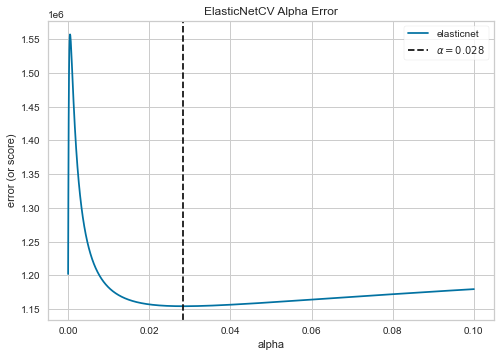

El score obtenido en el dataset de training fue de: 0.25029121870284077
El score obtenido en el dataset de testing fue de: 0.2335003857717357


In [98]:
model_eln = ElasticNetCV(cv = 3, l1_ratio=0.1, alphas = np.linspace(0,0.1,5000))
visualizer = AlphaSelection(model_eln)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

model_eln = ElasticNetCV(cv = 3, l1_ratio= visualizer.l1_ratio_, alphas = visualizer.alphas, tol = 0.01)

model_eln.fit(Xs_train, ys_train)
y_predict = model_eln.predict(Xs_test)
    
print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_eln.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))

In [52]:
import geopandas as geo

In [53]:
calles = geo.read_file("callejero-ba.txt").to_crs("EPSG:3395")

In [54]:
calles.nomoficial.value_counts(ascending = False)[:30]
STAFE = calles[calles.nomoficial == "SANTA FE AV."]

In [56]:
dptos = geo.GeoDataFrame(data2, geometry=geo.points_from_xy(data2.lon, data2.lat))
dptos = dptos.set_crs(epsg=4326)
dptos = dptos.to_crs("EPSG:3395")

In [167]:
a = []
for i in range(dptos.shape[0]):
    a.append(calles.geometry.distance(dptos.iloc[i,:].geometry).min())

In [66]:
calles_listado = ['DEL LIBERTADOR AV.', 'SANTA FE AV.', 'FIGUEROA ALCORTA, PRES. AV.', 'SARMIENTO AV.', 'CAMPOS, LUIS M. AV.', 
                  'LA PAMPA', 'BLANCO ENCALADA', 'JURAMENTO AV.', 'HERNANDEZ, JOSE', 'PINO, Virrey del', 'CABILDO AV.',
                 'PAZ, GRAL. AV.']

mascara = [x in calles_listado for x in calles.nomoficial]

calle = calles[mascara]

a = pd.DataFrame()

for i in dptos.geometry:
    distancias = calles.geometry.distance(i)
    distancias.name = "distancias"

    distancia_dpto = pd.merge(calle.nomoficial, distancias, right_index= True, left_index= True)
    
    c = list(distancia_dpto[distancia_dpto.distancias < 100].nomoficial.unique())
    
    if len(c) > 0:
        b = pd.DataFrame(np.ones_like(c).reshape(-1,len(c)), columns = c)
        a = pd.concat([a,b])
    else:
        a = a.append(pd.Series(), ignore_index=True)

a.index = dptos.index

In [40]:
calles.nomoficial[calles.BARRIO == "NUÑEZ"].value_counts()[:20]

PAZ, GRAL. AV.                                       54
3 DE FEBRERO                                         27
11 DE SEPTIEMBRE DE 1888                             24
PEDRAZA, MANUELA                                     23
CUBA                                                 23
VUELTA DE OBLIGADO                                   23
DEL LIBERTADOR AV.                                   23
ARCOS                                                23
O'HIGGINS                                            22
IBERA                                                20
RIVADAVIA MARTIN, COMODORO                           20
GRECIA                                               19
QUESADA                                              18
AZURDUY JUANA                                        15
NUÑEZ                                                15
COMPLEJO PARQUE DE LOS NIÑOS (Sin Nombre Oficial)    14
JARAMILLO                                            11
CABILDO AV.                                     

In [46]:
calles_listado = ['DEL LIBERTADOR AV.', 'SANTA FE AV.', 'FIGUEROA ALCORTA, PRES. AV.', 'SARMIENTO AV.', 'CAMPOS, LUIS M. AV.', 
                  'LA PAMPA', 'BLANCO ENCALADA', 'JURAMENTO AV.', 'HERNANDEZ, JOSE', 'PINO, Virrey del', 'CABILDO AV.',
                 'PAZ, GRAL. AV.']

a = calles.nomoficial

sum([x in calles_listado for x in a])

1194

In [68]:
a.notnull().sum()

DEL LIBERTADOR AV.             228
SANTA FE AV.                   140
CABILDO AV.                     36
CAMPOS, LUIS M. AV.             44
FIGUEROA ALCORTA, PRES. AV.     28
HERNANDEZ, JOSE                  1
PINO, Virrey del                 1
BLANCO ENCALADA                  1
dtype: int64